In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import chi2
import warnings


df = pd.read_csv("./data/house_idx.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df.set_index("DATE", inplace=True)
df["returns"] = df["CSUSHPINSA"].pct_change()
df.dropna(inplace=True)

df

,CSUSHPINSA,returns
DATE,,
1987-02-01,64.134,0.006260
1987-03-01,64.470,0.005239
1987-04-01,64.973,0.007802
1987-05-01,65.547,0.008834
1987-06-01,66.218,0.010237
...,...,...
2024-02-01,312.776,0.006170
2024-03-01,316.858,0.013051
2024-04-01,320.838,0.012561


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

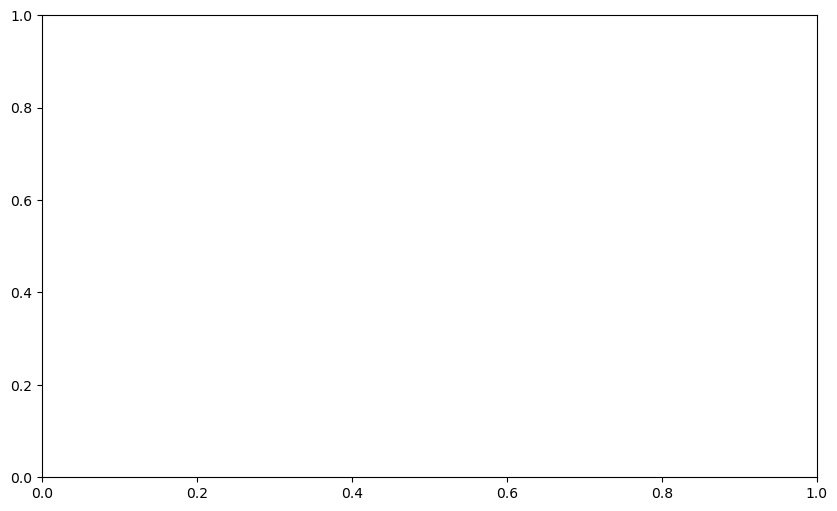

In [4]:
train_size = int(len(df) * 0.8)
train, test = df["returns"][:train_size], df["returns"][train_size:]

plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.title("Returns over time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [3]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
check_stationarity(train)

ADF Statistic: -2.585644
p-value: 0.096001
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
Non-stationary


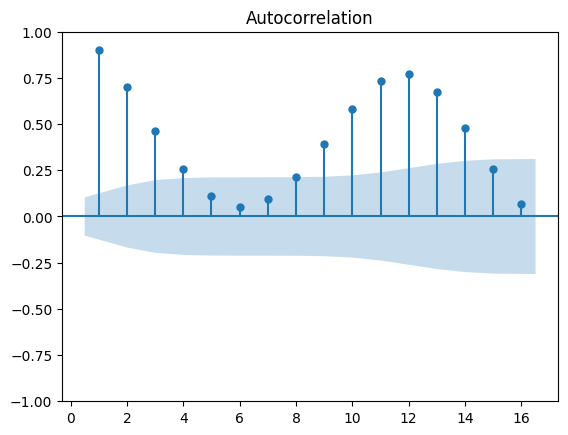

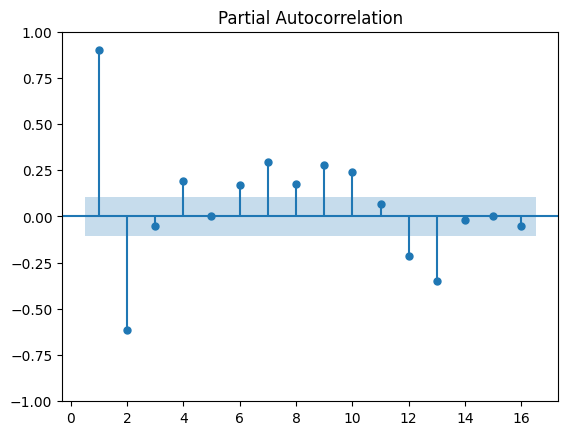

In [4]:
## compute the ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train, lags=16, zero=False)
plt.show()
plot_pacf(train, lags=16, zero=False)
plt.show()

In [5]:
## So we might want to use an AR(13) model or AR(2) (the correlations are significant up to a lag of 13):
from statsmodels.tsa.arima.model import ARIMA
aic = []
bic = []
indices = np.arange(1, 20)
warnings.filterwarnings("ignore")
for i in range(1, 15):
    model = ARIMA(train, order=(i, 0, 0))
    model_fit = model.fit()
    aic.append(model_fit.aic)
    bic.append(model_fit.bic)
warnings.filterwarnings("default")

In [6]:
aic = sorted(zip(aic,indices))
bic = sorted(zip(bic,indices))
aic,bic

([(-3524.577625787911, 13),
  (-3522.867055195776, 14),
  (-3476.7422190177886, 12),
  (-3459.8895597557766, 11),
  (-3459.8879298739084, 10),
  (-3440.0986928296716, 9),
  (-3411.9106617935677, 8),
  (-3402.706350177861, 7),
  (-3371.496156894823, 6),
  (-3365.1941915302473, 4),
  (-3363.1959939038998, 5),
  (-3355.2056157010556, 2),
  (-3353.7530257577605, 3),
  (-3183.7878472943016, 1)],
 [(-3466.327789960587, 13),
  (-3460.733896979964, 14),
  (-3422.375705578953, 12),
  (-3413.288061212049, 10),
  (-3409.406368705429, 11),
  (-3397.3821465563005, 9),
  (-3373.0774379086847, 8),
  (-3367.7564486814667, 7),
  (-3341.8942571993175, 4),
  (-3340.4295777869165, 6),
  (-3339.6723261471025, 2),
  (-3336.012737184482, 5),
  (-3334.3364138153192, 3),
  (-3172.137880128837, 1)])

/opt/homebrew/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


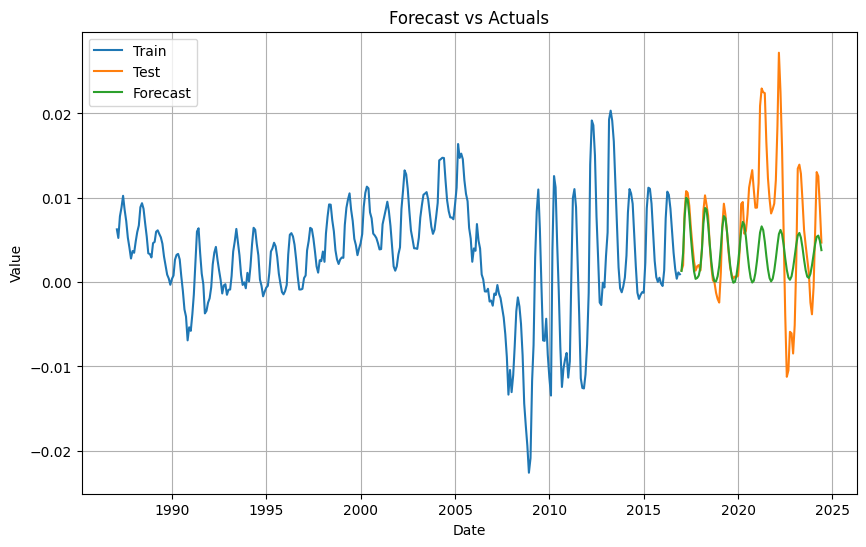

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                  359
Model:                ARIMA(13, 0, 0)   Log Likelihood                1777.289
Date:                Sat, 07 Sep 2024   AIC                          -3524.578
Time:                        09:47:49   BIC                          -3466.328
Sample:                    02-01-1987   HQIC                         -3501.414
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.002      1.372      0.170      -0.001       0.007
ar.L1          1.1372      0.037     30.671      0.000       1.065       1.210
ar.L2         -0.1724      0.053     -3.274      0.001      -0.276      -0.069
ar.L3         -0.2606      0.047     -5.504      0.000      -0.353      -0.168
ar.L4          0.2457      0.067      3.691      0.000       0.115       0.376
ar.L5         -0.0342      0.085     -0.402      0.687      -0.201       0.132
ar.L6         -0.1386      0.079     -1.760      0.078      -0.293       0.016
ar.L7          0.1131      0.081      1.398      0.162      -0.045       0.272
ar.L8         -0.0392      0.067     -0.584      0.559      -0.171       0.092
ar.L9          0.0356      0.070      0.509      0.611      -0.102       0.173
ar.L10        -0.0388      0.079     -0.490      0.624      -0.194       0.117
ar.L11         0.2540      0.064      3.952      0.000       0.128       0.380
ar.L12         0.2136      0.055      3.916      0.000       0.107       0.321
ar.L13        -0.3679      0.034    -10.937      0.000      -0.434      -0.302
sigma2      2.853e-06   1.41e-07     20.281      0.000    2.58e-06    3.13e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               875.78
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               6.40   Skew:                             0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
## Both AIC and BIC suggest that the best model is AR(14), which also agrees with the previous analysis. So we will use AR(14) model.
model = ARIMA(train, order=(13, 0, 0))
model_fit = model.fit()

plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, model_fit.forecast(len(test)), label='Forecast')
plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

model_fit.summary()

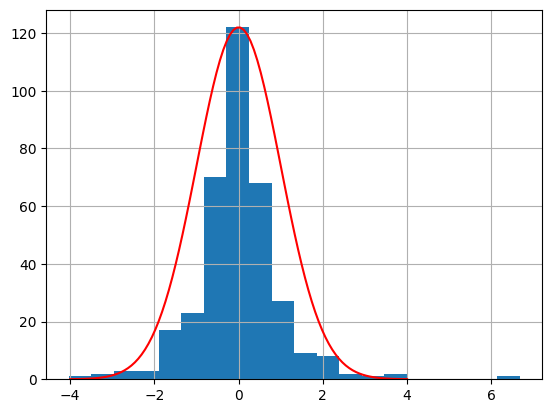

In [52]:
# make sure that the residuals are normally distributed and independant
residuals = model_fit.resid
normalized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
hist = normalized_residuals.hist(bins=20)
#display the normal distribution in comparison :
x = np.linspace(-4, 4, 100)
y = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi) * (np.sqrt(2 * np.pi) * 122)

plt.plot(x, y, 'r')
plt.show()

In [53]:
# Test for normal distribution
from scipy.stats import shapiro
shapiro(normalized_residuals)
# p is less than 0.05, so we reject the null hypothesis that the residuals are normally distributed

ShapiroResult(statistic=0.9130315184839589, pvalue=1.5564885611579337e-13)

In [54]:
# Test for independence
from statsmodels.stats.stattools import durbin_watson
durbin_watson(normalized_residuals)
# The Durbin-Watson statistic is close to 2, which suggests that the residuals are independent

2.0241278990218703